# Using Engines and Degraders to Generate Galaxy Samples with Errors and Biases

author: John Franklin Crenshaw, Sam Schmidt, Eric Charles, others...

last run successfully: March 16, 2022

This notebook demonstrates how to use a RAIL Engines to create galaxy samples, and how to use Degraders to add various errors and biases to the sample.

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the Engine. This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will first learn how to draw samples from a RAIL Engine object.
Then we will demonstrate how to use the following RAIL Degraders:
1. [**LSSTErrorModel**](#LSSTErrorModel), which adds photometric errors
2. [**QuantityCut**](#QuantityCut), which applies cuts to the specified columns of the sample
3. [**InvRedshiftIncompleteness**](#InvRedshiftIncompleteness), which introduces sample incompleteness
4. [**LineConfusion**](#LineConfusion), which introduces spectroscopic errors

Throughout the notebook, we will show how you can chain all these Degraders together to build a more complicated degrader.
Hopefully, this will allow you to see how you can build your own degrader.

*Note on generating redshift posteriors*: regardless of what Degraders you apply, when you use a Creator to estimate posteriors, the posteriors will *always* be calculated with respect to the "true" distribution. This is the whole point of the Creation Module -- you can generate degraded samples for which we still have access to the *true* posteriors. For an example of how to calculate posteriors, see `posterior-demo.ipynb`.

In [2]:
import matplotlib.pyplot as plt
from pzflow.examples import get_example_flow
from rail.creation import engines
from rail.creation.degradation import (
    InvRedshiftIncompleteness,
    LineConfusion,
    LSSTErrorModel,
    QuantityCut,
)
from rail.core.stage import RailStage

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Specify the path to the pretrained 'pzflow' used to generate samples

In [3]:
import pzflow
import os
flow_file = os.path.join(os.path.dirname(pzflow.__file__), 'examples', 'example-flow.pkl')

We'll start by setting up the Rail data store.  RAIL uses [ceci](https://github.com/LSSTDESC/ceci), which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively.  See the `rail/examples/goldenspike/goldenspike.ipynb` example notebook for more details on the Data Store.

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## "True" Engine

First, let's make an Engine that has no degradation. We can use it to generate a "true" sample, to which we can compare all the degraded samples below.

Note: in this example, we will use a normalizing flow engine from the [pzflow](https://github.com/jfcrenshaw/pzflow) package. However, everything in this notebook is totally agnostic to what the underlying engine is.

The Engine is a type of RailStage object, so we can make one using the `RailStage.make_stage` function for the class of Engine that we want.  We then pass in the configuration parameters as arguments to `make_stage`.

In [5]:
n_samples = int(1e4)
flowEngine_truth = engines.FlowEngine.make_stage(name='truth', flow=flow_file, n_samples=n_samples)

Inserting handle into data store.  flow: /net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/pzflow/examples/example-flow.pkl, truth


### Let's check that the Engine correctly read the underlying PZ Flow object

In [6]:
flowEngine_truth.get_data('flow')

### Now we invoke the `sample` method to generate some samples

Note that this will return a `DataHandle` object, which can keep both the data itself, and also the path to where the data is written.  When talking to rail stages we can use this as though it were the underlying data and pass it as an argument.  This allows the rail stages to keep track of where their inputs are coming from.

In [7]:
samples_truth = flowEngine_truth.sample(n_samples, seed=0)
print(samples_truth.data)
print("Data was written to ", samples_truth.path)

Inserting handle into data store.  output_truth: inprogress_output_truth.pq, truth
      redshift          u          g          r          i          z  \
0     0.860836  28.616596  28.088726  26.973406  25.777851  25.328173   
1     1.125769  25.296183  24.922346  24.403429  24.112925  23.595055   
2     0.809433  27.553078  27.107698  26.464060  25.624269  25.381008   
3     1.232695  28.011805  27.439817  26.704676  25.828514  24.960697   
4     1.772999  29.291903  27.931160  27.232056  26.652147  26.107920   
...        ...        ...        ...        ...        ...        ...   
9995  1.098335  27.222546  26.652248  25.925934  25.446163  24.794727   
9996  0.846982  25.434422  25.201889  24.508331  23.565773  23.030106   
9997  1.013073  28.314051  27.685015  26.820606  26.061916  25.393734   
9998  1.182513  27.159349  26.907515  26.561974  26.190626  25.564272   
9999  1.034542  24.663368  24.581011  24.343653  23.882557  23.282055   

              y  
0     25.215694  
1   

<a id="LSSTErrorModel"></a>
## Degrader 1: LSSTErrorModel

Now, we will demonstrate the `LSSTErrorModel`, which adds photometric errors using a model similar to the model from [Ivezic et al. 2019](https://arxiv.org/abs/0805.2366) (specifically, it uses the model from this paper, without making the high SNR assumption. To restore this assumption and therefore use the exact model from the paper, set `highSNR=True`.)

Let's create an error model with the default settings:

In [13]:
errorModel = LSSTErrorModel.make_stage(name='error_model', highSNR=True)

To see the details of the model, including the default settings we are using, you can just print the model:

Now let's add this error model as a degrader and draw some samples with photometric errors.

In [14]:
samples_w_errs = errorModel(samples_truth)
samples_w_errs.data

Inserting handle into data store.  output_error_model: inprogress_output_error_model.pq, error_model


,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.860836,25.563785,0.129599,28.613403,0.672939,26.845924,0.130239,25.758805,0.072219,25.321585,0.086916,25.078562,0.163172
1,1.125769,25.157372,0.089419,24.937454,0.023589,24.408758,0.014824,24.080251,0.016285,23.638568,0.019233,23.492068,0.038312
2,0.809433,26.941380,0.458872,27.259656,0.193670,26.421219,0.088213,25.620393,0.063642,25.453407,0.098075,25.064500,0.161077
3,1.232695,28.719339,2.356827,27.759560,0.306692,26.855946,0.131443,25.805445,0.075366,25.017121,0.065792,24.203045,0.073099
4,1.772999,28.660251,2.232028,28.092589,0.416660,26.982530,0.147652,26.638761,0.161874,26.416445,0.237566,26.769727,0.773563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.098335,27.264127,0.617464,26.708424,0.116746,25.878040,0.053709,25.394625,0.051810,24.760201,0.052061,24.692926,0.114506
9996,0.846982,25.512919,0.123707,25.171420,0.028964,24.508144,0.016073,23.579201,0.011035,23.036079,0.011853,22.835505,0.021430
9997,1.013073,27.347564,0.666729,27.563172,0.256007,26.833593,0.128772,26.194568,0.107650,25.462853,0.098928,25.649736,0.275908
9998,1.182513,26.826501,0.412874,26.832786,0.130855,26.502628,0.095046,26.022987,0.091978,25.533953,0.105593,25.377663,0.214818


Notice some of the magnitudes are NaN's. These are non-detections. This means those observed magnitudes were beyond the 30mag limit that is default in `LSSTErrorModel`. 
You can change this limit and the corresponding flag by setting `magLim=...` and `ndFlag=...` in the constructor for `LSSTErrorModel`. 

Let's plot the error as a function of magnitude

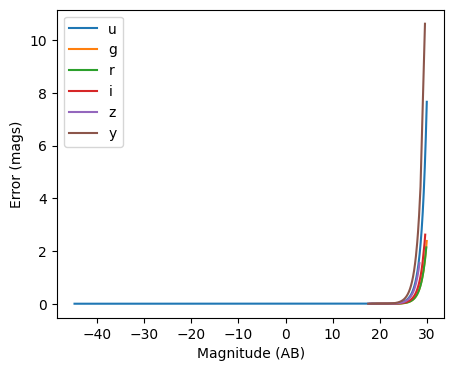

In [15]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

for band in "ugrizy":
    
    # pull out the magnitudes and errors
    mags = samples_w_errs.data[band].to_numpy()
    errs = samples_w_errs.data[band + "_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    ax.plot(mags, errs, label=band) 
    
ax.legend()
ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")
plt.show()

You can see that the photometric error increases as magnitude gets dimmer, just like you would expect. Notice, however, that we have galaxies as dim as magnitude 30. This is because the Flow produces a sample much deeper than the LSST 5-sigma limiting magnitudes. There are no galaxies dimmer than magnitude 30 because LSSTErrorModel sets magnitudes > 30 equal to NaN (the default flag for non-detections).

<a id="QuantityCut"></a>
## Degrader 2: QuantityCut

Recall how the sample above has galaxies as dim as magnitude 30. This is well beyond the LSST 5-sigma limiting magnitudes, so it will be useful to apply cuts to the data to filter out these super-dim samples. We can apply these cuts using the `QuantityCut` degrader. This degrader will cut out any samples that do not pass all of the specified cuts.

Let's make and run degraders that first adds photometric errors, then cuts at i<25.3, which is the LSST gold sample.

In [ ]:
gold_cut = QuantityCut.make_stage(name='cuts', cuts={"i": 25.3})                                

Now we can stick this into a Creator and draw a new sample

In [ ]:
samples_gold_w_errs = gold_cut(samples_w_errs)

If you look at the i column, you will see there are no longer any samples with i > 25.3. You can also see that despite making the cut on the i band, there are still 100000 samples as requested. This is because after making the cut, the creator will draw more samples (and re-apply the cut) iteratively until you have as many samples as originally requested. 

One more note: it is easy to use the QuantityCut degrader as a SNR cut on the magnitudes. The magnitude equation is $m = -2.5 \log(f)$. Taking the derivative, we have
$$
dm = \frac{2.5}{\ln(10)} \frac{df}{f} = \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
So if you want to make a cut on galaxies above a certain SNR, you can make a cut
$$
dm < \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
For example, an SNR cut on the i band would look like this: `QuantityCut({"i_err": 2.5/np.log(10) * 1/SNR})`.

<a id="InvRedshiftIncompleteness"></a>
## Degrader 3: InvRedshiftIncompleteness

Next, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

In [ ]:
inv_incomplete = InvRedshiftIncompleteness.make_stage(name='incompleteness', pivot_redshift=0.8)

In [ ]:
samples_incomplete_gold_w_errs = inv_incomplete(samples_gold_w_errs)

Let's plot the redshift distributions of the samples we have generated so far:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth.data["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs.data["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs.data["redshift"], label="Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the Gold sample has significantly fewer high-redshift galaxies than the truth. This is because many of the high-redshift galaxies have i > 25.3.

You can further see that the Incomplete Gold sample has even fewer high-redshift galaxies. This is exactly what we expected from this degrader.

<a id="LineConfusion"></a>
## Degrader 4: LineConfusion

`LineConfusion` is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

For this example, let's use the degrader to simulate a scenario in which which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines. (note I do not know how realistic this scenario is!)

In [ ]:
OII = 3727
OIII = 5007

lc_2p_0II_0III = LineConfusion.make_stage(name='lc_2p_0II_0III',
                                          true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)
lc_1p_0III_0II = LineConfusion.make_stage(name='lc_1p_0III_0II',
                                          true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)

In [ ]:
samples_conf_inc_gold_w_errs = lc_1p_0III_0II(lc_2p_0II_0III(samples_incomplete_gold_w_errs))

Let's plot the redshift distributions one more time

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth.data["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs.data["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs.data["redshift"], label="Incomplete Gold", **hist_settings)
ax.hist(samples_conf_inc_gold_w_errs.data["redshift"], label="Confused Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the redshift distribution of this new sample is essentially identical to the Incomplete Gold sample, with small perturbations that result from the line confusion. 

However the real impact of this degrader isn't on the redshift distribution, but rather that it introduces erroneous spec-z's into the photo-z training sets! To see the impact of this effect, let's plot the true spec-z's as present in the Incomplete Gold sample, vs the spec-z's listed in the new sample with Oxygen Line Confusion.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=85)

ax.scatter(samples_incomplete_gold_w_errs.data["redshift"], samples_conf_inc_gold_w_errs.data["redshift"], 
           marker=".", s=1)

ax.set(
    xlim=(0, 2.5), ylim=(0, 2.5),
    xlabel="True spec-z (in Incomplete Gold sample)",
    ylabel="Spec-z listed in the Confused sample",
)
plt.show()

Now we can clearly see the spec-z errors! The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.